In [35]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# %matplotlib inline
# mpl.pyplot.style.use('default')
# mpl.pyplot.close('all')

# font, rcnew = plot_utils.matplotlib_default_config()
# mpl.rc('font', **font)
# mpl.pyplot.rcParams.update(rcnew)
# mpl.pyplot.style.use('tableau-colorblind10')
# %config InlineBackend.figure_format = 'retina'

# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12

In [37]:
param_names_key = ['omega_cold', 'sigma8_cold', 'b1']
param_names_key_rp = ['omega_cold', 'sigma8_cold', 'sigma8_cold_x_b1']
param_names_bias = ['b2', 'bs2', 'bl']
param_names_bias_rp = ['sigma8_cold_sq_x_b2', 'sigma8_cold_sq_x_bs2', 'sigma8_cold_x_bl']
param_names_noise_rp = ['An_homog', 'sigma8_cold_x_An_b1', 'sigma8_cold_sq_x_An_b2', 'sigma8_cold_sq_x_An_bs2', 'sigma8_cold_x_An_bl']

# test on single

In [38]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
dir_mocks = f'/cosmos_storage/simulations/BaccoSims/muchisimocks/muchisimocks_lib{tag_params}'
#dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
bias_terms_eul = np.load(fn_fields)


In [39]:
#the order is b1, b2, bs2, blaplacian
#bias_params = [1, 0, 0, 0]
bias_params = [1.2, 0.5, 0.25, 5]

# use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
# this doesn't matter for visualization, but will when you go to compute statistics
n_grid_orig = 512
tracer_field = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)

In [40]:
box_size = 1000 # Mpc/h
n_grid = 128 

In [42]:
params_df, param_dict_fixed = data_loader.load_cosmo_params(tag_params)
print(params_df)
param_dict = params_df.loc[idx_LH].to_dict()
cosmo = utils.get_cosmo(param_dict)

      omega_cold  sigma8_cold    hubble  omega_baryon        ns
0       0.236617     0.697564  0.663683      0.048591  0.957079
1       0.337168     0.793531  0.602884      0.052822  0.959740
2       0.285414     0.852452  0.730887      0.053568  0.969280
3       0.238496     0.686086  0.714819      0.050500  0.967325
4       0.274884     0.893641  0.600121      0.057412  0.981679
...          ...          ...       ...           ...       ...
9995    0.281629     0.682273  0.783502      0.051098  0.951428
9996    0.310038     0.842970  0.706149      0.053284  0.979408
9997    0.299789     0.865812  0.676875      0.057476  0.938394
9998    0.351611     0.858341  0.704226      0.045547  0.963179
9999    0.341659     0.786988  0.708020      0.054471  0.924276

[10000 rows x 5 columns]


In [43]:
pk_obj = cs.compute_pk(tracer_field, cosmo, box_size, n_grid_orig)

Computing pk, using n_grid =  128


2026-01-30 08:56:19,312 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-30 08:56:19,743 bacco.statistics :  ...done in 0.431 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.005363 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.045453 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000165 secs
bacco.power : Deallocating arrays


In [44]:
matter_density_field = bias_terms_eul[1]
pgm_obj = cs.compute_pgm(tracer_field, matter_density_field, cosmo, box_size, n_grid_orig)

Computing pgm, using n_grid =  128


2026-01-30 08:56:23,057 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-30 08:56:23,188 bacco.statistics :  ...done in 0.131 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 6.31307e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.031130 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.052532 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000150 secs
bacco.power : Deallocating arrays


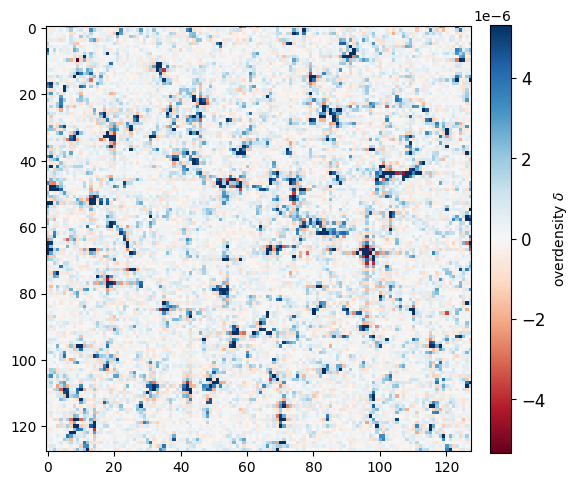

In [45]:
plotter.plot_field(tracer_field, overdensity=True)

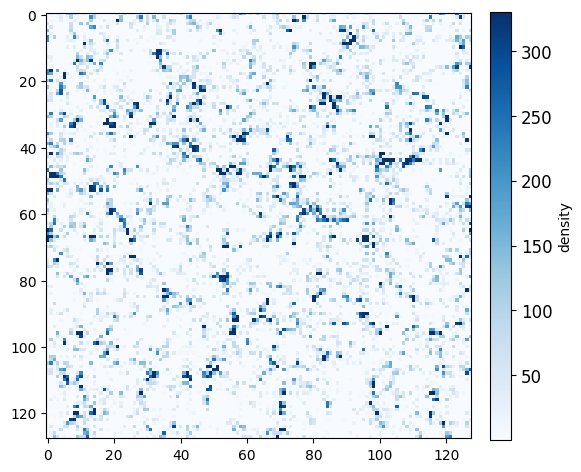

In [46]:
plotter.plot_field(matter_density_field, overdensity=False)

In [47]:
pk_obj = cs.compute_pk(tracer_field, cosmo, box_size, n_grid_orig)

Computing pk, using n_grid =  128


2026-01-30 08:57:02,700 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-30 08:57:02,789 bacco.statistics :  ...done in 0.0893 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.007631 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.048627 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000150 secs
bacco.power : Deallocating arrays


/tmp/ipykernel_172368/847835007.py:15: RuntimeWarning: invalid value encountered in divide
  frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']


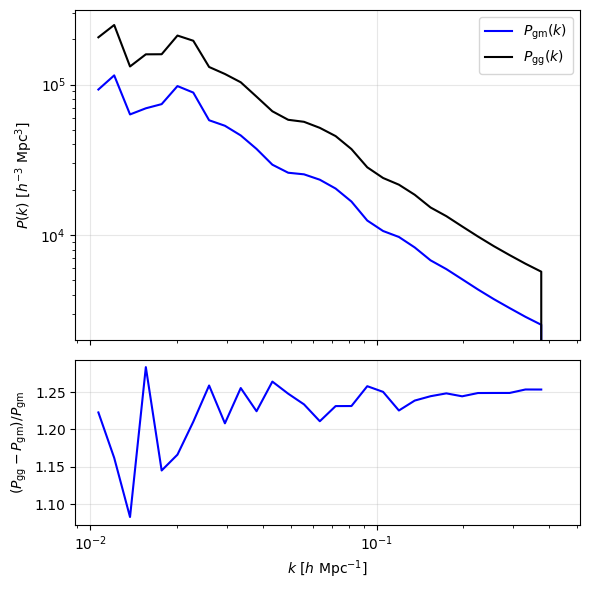

In [48]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Upper panel: power spectra
ax1.plot(pgm_obj['k'], pgm_obj['pk'], label=r'$P_{\rm gm}(k)$', color='blue')
ax1.plot(pk_obj['k'], pk_obj['pk'], label=r'$P_{\rm gg}(k)$', color='k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lower panel: fractional difference
# Assume k bins are the same
frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']

ax2.plot(pgm_obj['k'], frac_diff, color='blue', linewidth=1.5)
#ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$')
ax2.set_ylabel(r'$(P_{\rm gg} - P_{\rm gm}) / P_{\rm gm}$')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# shame

In [2]:
from process_catalogs import round_to_nearest_even

In [3]:
data_mode = 'shame'
cosmo = utils.get_cosmo(utils.cosmo_dict_shame)
box_size_mock = 1024.0
box_size_muchisimocks = 1000.0
n_grid_orig = 512
n_grid = 128
n_grid_orig_mock = round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid_orig))
n_grid_mock = round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid))
print(n_grid_orig_mock)

524


In [4]:
tag_mock = '_nbar0.00022'
fn_cat0_mesh = f'../data/data_{data_mode}/data{tag_mock}/tracer_field_phase0.npy'
tracer_field0 = np.load(fn_cat0_mesh)
print(tracer_field0.shape)

(132, 132, 132)


In [5]:
sim_dir = '/cosmos_storage/simulations/BaccoSims/Rings/N3072_L1024/Planck_N3072_L1024.0_output/0.00'
z = '0.0'
a = 1/(1+np.float64(z))

sim = bacco.Simulation(basedir=sim_dir, halo_file='groups_%03d/fof_subhalo_history_tab_orph_wweight_%03d'%(49, 49),
                       use_orphans=True, closest_expfactor = 1/(1+float(z)),usememcache=True)

2026-01-30 08:20:50,852 bacco.sims : Initialising simulation Default
2026-01-30 08:20:50,853 bacco.sims : try /cosmos_storage/simulations/BaccoSims/Rings/N3072_L1024/Planck_N3072_L1024.0_output/0.00/groups_049/fof_subhalo_history_tab_orph_wweight_049
2026-01-30 08:20:50,919 bacco.sims : Loading /cosmos_storage/simulations/BaccoSims/Rings/N3072_L1024/Planck_N3072_L1024.0_output/0.00/groups_049/fof_subhalo_history_tab_orph_wweight_049
2026-01-30 08:20:50,938 bacco.cosmo :    initialization took 0.000 secs
2026-01-30 08:20:51,020 bacco.sims : ...done in 0.0877 s


In [22]:
BoxSize = sim.header['BoxSize']
print(BoxSize)
assert BoxSize == box_size_mock

1024.0


In [ ]:
dens_field_ngorig = bacco.statistics.compute_mesh(ngrid=n_grid_orig_mock, box=box_size_mock, 
                                    pos=sim.sdm['pos'], 
                                    deposit_method='cic', 
                                    interlacing=False,
                                    #interlacing=True,
                                    #compensated=False, # does not exist, will break
                                    cosmology=sim.Cosmology
                                    )

2026-01-30 08:26:47,701 bacco.statistics : Computing cic mesh with ngrid=524 and interlacing=False
2026-01-30 08:26:47,702 bacco.statistics : starting deposit 1
2026-01-30 08:26:49,542 bacco.statistics :  mesh done in 1.84 s


bacco.mesh : boxsize=1024.000000 ngrid=524, nthreads=48, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 548.9 Mb
bacco.mesh : binning of 452984832 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [30]:
from bacco.powerspectrum import power

In [32]:
# dep_method = 1 # CiC
# nthreads = 4
# verbose = 0
# interlacing = False
# dens_field_ngorig_compensated = power.deconvolved_interlaced_density_grid(dens_field_ngorig, int(n_grid_orig_mock), float(box_size_mock),
#                                                         int(interlacing), int(dep_method),
#                                                         1, int(nthreads),
#                                                         int(verbose))

In [9]:
dens_field_ngorig.shape

(1, 524, 524, 524)

In [10]:
# Remove high-k modes to downsample
dens_field_kcut = utils.remove_highk_modes(dens_field_ngorig[0], box_size_mock=box_size_mock, n_grid_target=n_grid_mock)

# tested in data_creation_pipeline that doing kcut then deconvolve is basically equivalent to deconvolve then kcut,
# and much faster
import bacco.probabilistic_bias as pb
dens_field_kcut_deconvolved = pb.convolve_linear_interpolation_kernel(dens_field_kcut, 
                                                                    npix=n_grid_orig_mock, mode="deconvolve")

/tmp/ipykernel_172368/728486832.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  dens_field_kcut_deconvolved = pb.convolve_linear_interpolation_kernel(dens_field_kcut,


In [ ]:
dens_field0 = dens_field_kcut_deconvolved
print(dens_field0.shape)

In [23]:
dens_field_ngorig_interlacing = bacco.statistics.compute_mesh(ngrid=n_grid_orig_mock, box=box_size_mock, 
                                    pos=sim.sdm['pos'], 
                                    deposit_method='cic', 
                                    interlacing=True,
                                    #compensated=False, # does not exist, will break
                                    cosmology=sim.Cosmology
                                    )

2026-01-30 08:36:08,934 bacco.statistics : Computing cic mesh with ngrid=524 and interlacing=True
2026-01-30 08:36:08,935 bacco.statistics : starting deposit 1
2026-01-30 08:36:25,039 bacco.statistics :  mesh done in 16.1 s


bacco.mesh : boxsize=1024.000000 ngrid=524, nthreads=8, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 1097.7 Mb
bacco.mesh : binning of 452984832 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [24]:
# Remove high-k modes to downsample
dens_field_kcut_interlacing = utils.remove_highk_modes(dens_field_ngorig_interlacing[0], box_size_mock=box_size_mock, n_grid_target=n_grid_mock)

# tested in data_creation_pipeline that doing kcut then deconvolve is basically equivalent to deconvolve then kcut,
# and much faster
import bacco.probabilistic_bias as pb
dens_field_kcut_deconvolved_interlacing = pb.convolve_linear_interpolation_kernel(dens_field_kcut_interlacing, 
                                                                    npix=n_grid_orig_mock, mode="deconvolve")

/tmp/ipykernel_172368/570350328.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  dens_field_kcut_deconvolved_interlacing = pb.convolve_linear_interpolation_kernel(dens_field_kcut_interlacing,


In [25]:
dens_field0_interlacing = dens_field_kcut_deconvolved_interlacing
print(dens_field0_interlacing.shape)

(132, 132, 132)


In [ ]:
# #dens_field0 = dens_field0_kcut_deconvolved
# fn_dens0_mesh = f'../data/data_{data_mode}/dens_mesh_phase0.npy'
# dens_field0 = np.load(fn_dens0_mesh)
# print(dens_field0.shape)

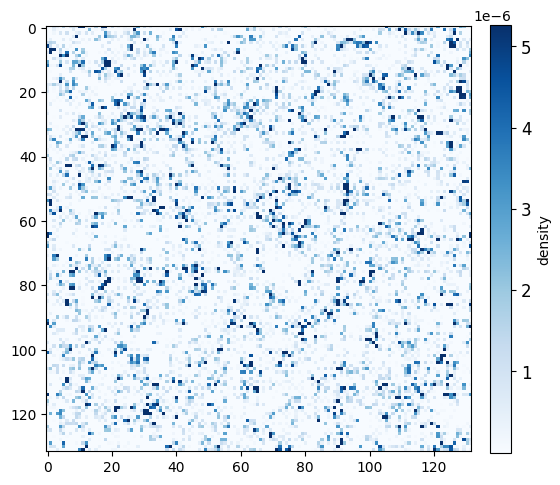

In [12]:
plotter.plot_field(tracer_field0, overdensity=False)

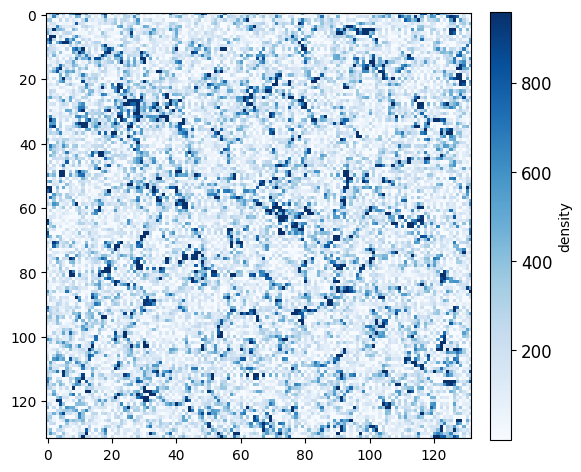

In [ ]:
plotter.plot_field(dens_field0, overdensity=False)

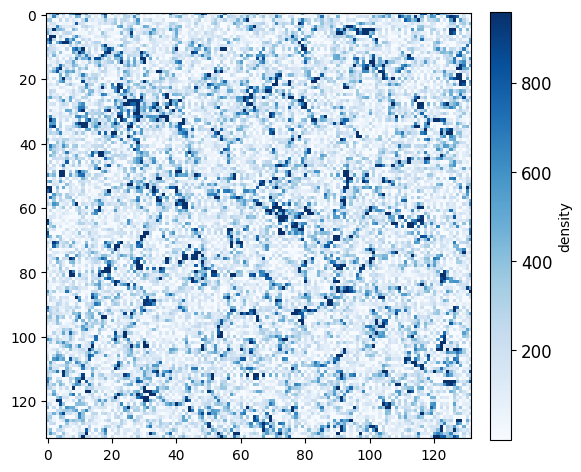

In [26]:
plotter.plot_field(dens_field0_interlacing, overdensity=False)

In [33]:
pgm_obj_shame = cs.compute_pgm(tracer_field0, dens_field0/n_grid_orig_mock**3, cosmo, box_size_mock, n_grid_orig_mock)

Computing pgm, using n_grid =  132


2026-01-30 08:53:08,314 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2026-01-30 08:53:08,457 bacco.statistics :  ...done in 0.143 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -6.16393e-11 (grid1) 2.18824e-08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.022590 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.059274 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays


In [ ]:
pgm_obj_shame_interlacing = cs.compute_pgm(tracer_field0, dens_field0_interlacing, cosmo, box_size_mock, n_grid_orig_mock)

Computing pgm, using n_grid =  132


2026-01-30 08:37:59,487 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -6.16393e-11 (grid1) 3.1484 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.062422 sec
bacco.power : Counting modes


2026-01-30 08:37:59,727 bacco.statistics :  ...done in 0.24 s


bacco.power : done counting modes in 0.087343 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000148 secs
bacco.power : Deallocating arrays


In [15]:
pk_obj_shame = cs.compute_pk(tracer_field0, cosmo, box_size_mock, n_grid_orig_mock)

Computing pk, using n_grid =  132


2026-01-30 08:32:01,212 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -6.16393e-11 (grid1) -6.16393e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.053788 sec
bacco.power : Counting modes


2026-01-30 08:32:01,465 bacco.statistics :  ...done in 0.253 s


bacco.power : done counting modes in 0.117537 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000146 secs
bacco.power : Deallocating arrays


In [16]:
pmm_obj_shame = cs.compute_pk(dens_field0/n_grid_orig_mock**3, cosmo, box_size_mock, n_grid_orig_mock)

Computing pk, using n_grid =  132


2026-01-30 08:32:03,283 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 3.1484 (grid1) 3.1484 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.043163 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.089130 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000275 secs
bacco.power : Deallocating arrays


2026-01-30 08:32:03,487 bacco.statistics :  ...done in 0.204 s


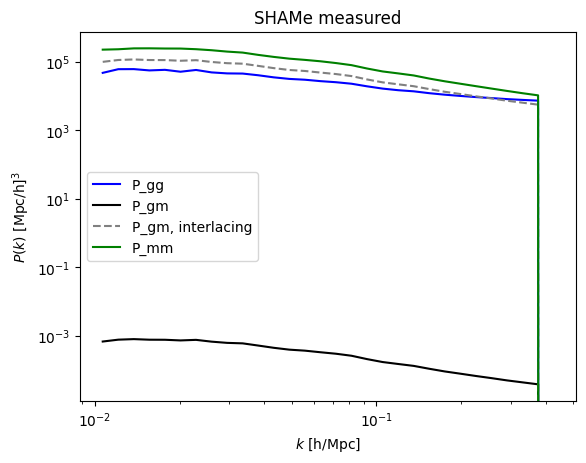

In [34]:
plt.title('SHAMe measured')
plt.plot(pk_obj_shame['k'], pk_obj_shame['pk'], label=f'P_gg', color='blue')
plt.plot(pgm_obj_shame['k'], pgm_obj_shame['pk'], label='P_gm', color='black')
plt.plot(pgm_obj_shame_interlacing['k'], pgm_obj_shame_interlacing['pk'], label='P_gm, interlacing', color='grey', ls='--')
plt.plot(pmm_obj_shame['k'], pmm_obj_shame['pk'], label='P_mm', color='green')
plt.legend()
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Load and plot

In [11]:
data_mode = 'muchisimocks'
statistics = ['pk', 'pgm']
#statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_unit_p5_n10000'
# tag_Anoise = '_Anmult_p5_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
#tag_noise = '_noise_unit_test_p5_n1000'
#tag_Anoise = '_Anmult_p5_n1000'
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
tag_noise = None
tag_Anoise = None
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
if tag_noise is None:
    tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
else:
    tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_noise + tag_Anoise + tag_datagen
k_arr, y_arr, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000
Found 1000 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000


Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_pk_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_pk_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt (already exists)
Masked 1 out of 30 bins
(29,) (1000, 29) (1000, 29)
dir_statistics: /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Found 1000 diff cosmo pgms in /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Loaded pgm data with shape (1000, 30)
fn_mask: ../data/masks/mask_pgm_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt
Saving mask to ../data/masks/mask_pgm_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt
Mask masks out 1 Pgm bins
Masked 1 out of 30 bins
(29,) (1000, 29) (1000, 29)
(1000, 29)


In [12]:
theta, param_names = data_loader.param_dfs_to_theta(idxs_params, params_df, biasparams_df, Anoise_df=Anoise_df)

In [13]:
# unpack the stats
k_pk = k_arr[statistics.index('pk')]
y_pk = y_arr[statistics.index('pk')]

k_pgm = k_arr[statistics.index('pgm')]
y_pgm = y_arr[statistics.index('pgm')]

# k_bispec = k_arr[statistics.index('bispec')]
# y_bispec = y_arr[statistics.index('bispec')]


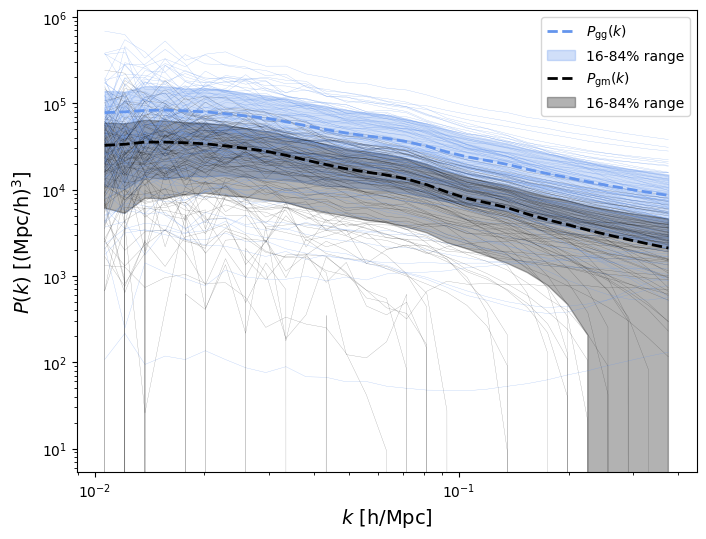

In [14]:

plt.figure(figsize=(8,6))

n_plot = np.min([100, y_pk.shape[0]])
first = True
for i in range(n_plot):
    label = None
    plt.plot(k_pk, y_pk[i], color='cornflowerblue', alpha=0.6, lw=0.2, label=label)
    plt.plot(k_pgm, y_pgm[i], color='black', alpha=0.4, lw=0.2, label=label)

mean = np.mean(y_pk, axis=0)
p16 = np.percentile(y_pk, 16, axis=0)
p84 = np.percentile(y_pk, 84, axis=0)
plt.plot(k_pk, mean, color='cornflowerblue', lw=2, ls='--', label=r'$P_{\rm gg}(k)$')
plt.fill_between(k_pk, p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')

mean = np.mean(y_pgm, axis=0)
p16 = np.percentile(y_pgm, 16, axis=0)
p84 = np.percentile(y_pgm, 84, axis=0)
plt.plot(k_pgm, mean, color='black', lw=2, ls='--', label=r'$P_{\rm gm}(k)$')
plt.fill_between(k_pgm, p16, p84, color='black', alpha=0.3, label=r'16-84% range')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10)